# <b>Fast Food: Case Study</b>



##### The task at hand is to work as a data analyst at McDonald's and to identify whether there are underlying segments that can help increase profit. 

In [71]:
# Importing the dependencies 

# The classics 
import pandas as pd 
import numpy as np 
import seaborn as sns 

# To fetch data from browser 
import requests 
import os 
import io 
import warnings 
import re 

from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score 
from sklearn.utils import resample 
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import confusion_matrix 
from sklearn.cluster import SpectralBiclustering

from statsmodels.graphics.mosaicplot import mosaic 
from yellowbrick.features.pca import PCADecomposition
from matplotlib import pyplot as plt 
from plotly import express as px 
from IPython.display import display 
from sklearn import set_config 
from tqdm import tqdm 

sns.set_style('darkgrid')
set_config(display = 'diagram')
warnings.simplefilter('ignore')

In [2]:
# Fetching the data from the browser 

REPOSITORY = 'https://homepage.boku.ac.at/leisch/MSA/datasets/mcdonalds.csv'
USER_AGENT = os.environ['USER_AGENT']

mc_donalds = pd.read_csv(REPOSITORY)

display(mc_donalds)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,No,Yes,No,Yes,Yes,No,No,No,Yes,No,Yes,I hate it!-5,47,Once a year,Male
1449,Yes,Yes,No,Yes,No,No,Yes,Yes,No,Yes,No,+2,36,Once a week,Female
1450,Yes,Yes,No,Yes,No,Yes,No,Yes,Yes,No,No,+3,52,Once a month,Female
1451,Yes,Yes,No,No,No,Yes,Yes,Yes,No,Yes,No,+4,41,Every three months,Male


##### Seems Too many binary variables to extract from, roughly speaking we might have to implement VSBD or Biclustering to eliminate useless variables.

#### <b>Exploring the dataset</b>

In [3]:
# Ostensible attributes 

display(mc_donalds.columns.values.tolist())

display(mc_donalds.sample(5)) 

display(mc_donalds.shape)

mc_donalds.info()



['yummy',
 'convenient',
 'spicy',
 'fattening',
 'greasy',
 'fast',
 'cheap',
 'tasty',
 'expensive',
 'healthy',
 'disgusting',
 'Like',
 'Age',
 'VisitFrequency',
 'Gender']

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
41,Yes,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,No,+3,57,More than once a week,Male
443,Yes,Yes,No,No,No,No,Yes,Yes,No,Yes,No,+3,67,Every three months,Female
524,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,No,+2,52,Once a month,Female
473,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,+3,33,Every three months,Male
474,No,No,No,Yes,Yes,Yes,Yes,No,No,No,Yes,I hate it!-5,24,Never,Female


(1453, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   yummy           1453 non-null   object
 1   convenient      1453 non-null   object
 2   spicy           1453 non-null   object
 3   fattening       1453 non-null   object
 4   greasy          1453 non-null   object
 5   fast            1453 non-null   object
 6   cheap           1453 non-null   object
 7   tasty           1453 non-null   object
 8   expensive       1453 non-null   object
 9   healthy         1453 non-null   object
 10  disgusting      1453 non-null   object
 11  Like            1453 non-null   object
 12  Age             1453 non-null   int64 
 13  VisitFrequency  1453 non-null   object
 14  Gender          1453 non-null   object
dtypes: int64(1), object(14)
memory usage: 170.4+ KB


* Everything except age is an object which is wrong. 
* No one from the sample thinks mc donalds is spicy which is interesting. 
* All of them think mc donalds is fast and tasty and not disgusting so it will be interesting to find out which factor is the reason for their success 
* Visit frequencies are low. It could be interesting to find out why

In [4]:
# Converting the available binary data to numeric and extract numbers from Like columns. 

class LikePreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, pattern = r'[-+]?\d+'):
        self.__name = 'like-preprocessor'
        self.pattern = re.compile(pattern)

    def __cleaner(self, text):
        return int(re.findall(self.pattern, text)[0]) 
    
    def fit(self, X, y = None):
        self.__X = pd.DataFrame(X).iloc[:, 0].apply(self.__cleaner)
        return self 
    
    def transform(self, X, y = None):
        return self.__X.values.reshape(-1, 1)
    
    def __repr__(self):
        return self.__name 
    

ct = ColumnTransformer([
    ('ordinal_encoder', OrdinalEncoder(categories = [['No', 'Yes'] for i in range(0, 11)]), slice(0, 11)), 
    ('column_cleaner', LikePreprocessor(), [11]),  
    ('ordinal_gender', OrdinalEncoder(categories=[['Male', 'Female']]), [14])
], remainder = 'passthrough')

ct.fit(mc_donalds.values)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal_encoder',
                                 OrdinalEncoder(categories=[['No', 'Yes'],
                                                            ['No', 'Yes'],
                                                            ['No', 'Yes'],
                                                            ['No', 'Yes'],
                                                            ['No', 'Yes'],
                                                            ['No', 'Yes'],
                                                            ['No', 'Yes'],
                                                            ['No', 'Yes'],
                                                            ['No', 'Yes'],
                                                            ['No', 'Yes'],
                                                            ['No', 'Yes']]),
                                 slice(0, 11, None)),
                                ('column_cleaner',
                                 LikePreprocessor(pattern=re.compile('[-+]?\\d+')),
                                 [11]),
                                ('ordinal_gender',
                                 OrdinalEncoder(categories=[['Male',
                                                             'Female']]),
                                 [14])])

In [5]:
column_list = ['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Gender', 'Age', 'VisitFrequency']
mcdonalds = pd.DataFrame(ct.transform(mc_donalds.values), columns = column_list) 
display(mcdonalds)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Gender,Age,VisitFrequency
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-3,1.0,61,Every three months
1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2,1.0,51,Every three months
2,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1,1.0,62,Every three months
3,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,4,1.0,69,Once a week
4,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2,0.0,49,Once a month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,-5,0.0,47,Once a year
1449,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2,1.0,36,Once a week
1450,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,3,1.0,52,Once a month
1451,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,4,0.0,41,Every three months


In [6]:
# This because it wasn't switching data type by 'astype' or pd.to_numeric 

def generate_numeric(data):
    matrix = []
    for i in range(0, 14):
        matrix.append(pd.to_numeric(data.iloc[:, i]).values) 

    return np.array(matrix)

temp = pd.DataFrame(generate_numeric(mcdonalds).T, columns = column_list[:-1])
temp['VisitFrequency'] = mcdonalds.VisitFrequency
temp.info()

mcdonalds = temp.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   yummy           1453 non-null   float64
 1   convenient      1453 non-null   float64
 2   spicy           1453 non-null   float64
 3   fattening       1453 non-null   float64
 4   greasy          1453 non-null   float64
 5   fast            1453 non-null   float64
 6   cheap           1453 non-null   float64
 7   tasty           1453 non-null   float64
 8   expensive       1453 non-null   float64
 9   healthy         1453 non-null   float64
 10  disgusting      1453 non-null   float64
 11  Like            1453 non-null   float64
 12  Gender          1453 non-null   float64
 13  Age             1453 non-null   float64
 14  VisitFrequency  1453 non-null   object 
dtypes: float64(14), object(1)
memory usage: 170.4+ KB


In [7]:
mcdonalds.describe()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Gender,Age
count,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000
mean,0.552650,0.907777,0.093599,0.867171,0.526497,0.900206,0.598761,0.644184,0.357880,0.198899,0.242946,0.777013,0.542326,44.604955
std,0.497391,0.289440,0.291371,0.339506,0.499469,0.299828,0.490318,0.478925,0.479542,0.399309,0.429010,3.116842,0.498377,14.221178
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,0.000000,18.000000
25%,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,33.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,45.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,1.000000,57.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,71.000000


* Cheap and Expensive seem like redundant columns because logically speaking cheap and redundant should be complements of each other. In the mean sections as well, mean(cheap) ~= 1 - mean(expensive)

* Most people come here because it's fast and convenient. Seems like a good segmentation variable, if we aim to improve our efficiency. 

In [8]:
pca = PCA()
pca.fit(mcdonalds.iloc[:, :11])
pca.explained_variance_ratio_.cumsum()


array([0.29944723, 0.49224445, 0.6252898 , 0.70838558, 0.7678661 ,
       0.81816566, 0.86201476, 0.90156255, 0.93832345, 0.97067674,
       1.        ])

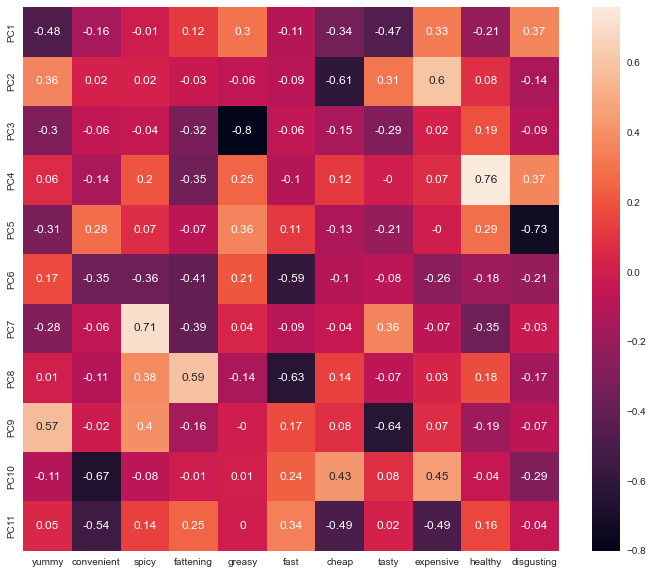

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(pca.components_.round(2), index = [f'PC{i}' for i in range(1, 12)], columns=column_list[:11]), annot = True ) 
plt.show()

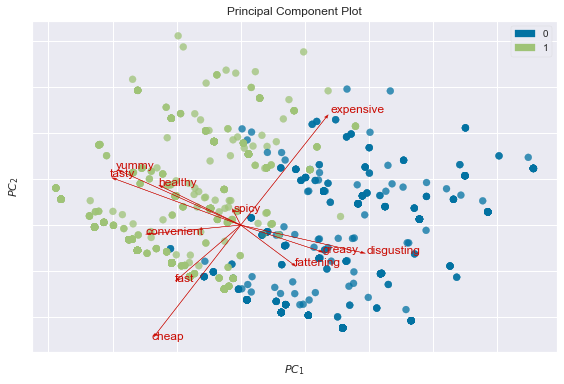

In [10]:
kmeans = KMeans(n_clusters=2)
pca = PCA(n_components=2)
kmeans.fit(mcdonalds.iloc[:, :11])
trf_X = pca.fit_transform(mcdonalds.iloc[:, :11])
X, y = mcdonalds.iloc[:, :11], kmeans.labels_

kmeans.fit(trf_X)

visualizer = PCADecomposition(scale = True, color = None, proj_features=True)
visualizer.fit_transform(X, y)
visualizer.show()
plt.show()

#### Using KMeans

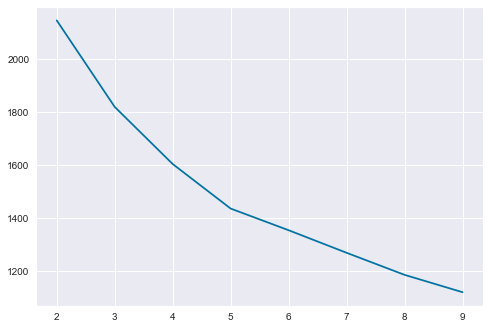

In [24]:
def kmeans_analyser(data, cluster_range: tuple):
    min_cls, max_cls = cluster_range 
    inertials = []
    clusters = []
    cluster_map = dict()
    for n_cls in range(min_cls, max_cls+1):
        kmeans = KMeans(n_clusters=n_cls)
        kmeans.fit(data)

        inertials.append(kmeans.inertia_)
        clusters.append(n_cls)

        inertia = kmeans.inertia_
        predictions = kmeans.labels_
        
        cluster_map[n_cls] = {"predictions":predictions, "inertia":inertia, "model":kmeans}

    sns.lineplot(x = clusters, y = inertials)
    plt.show()
    return cluster_map 


mapper_km = kmeans_analyser(mcdonalds.iloc[:, :11], cluster_range=(2, 9))


* No elbow point can be found
* We should try a different method

#### Model based clustering algorithm

100%|██████████| 11/11 [00:00<00:00, 15.58it/s]


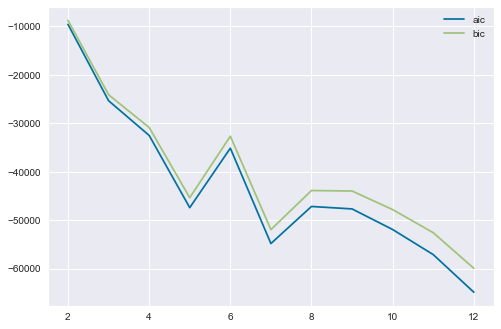

In [25]:
def cluster_analyzer(data, cluster_range: tuple):
    min_cls, max_cls = cluster_range 
    cluster_map = {}
    aic_scores, bic_scores = [], []
    n_cls = []

    for n in tqdm(range(min_cls, max_cls+1)) :
        model = GaussianMixture(n, covariance_type='full')
        model.fit(data)
        aic_scores.append(model.aic(data)) 
        bic_scores.append(model.bic(data))
        n_cls.append(n)
        cluster_map[n] = {"predictions":model.predict(data), "aic":model.aic(data), "bic":model.bic(data), "model":model}

    plt.plot(n_cls, aic_scores, label = 'aic')
    plt.plot(n_cls, bic_scores, label = 'bic')
    plt.legend()
    plt.show()

    return cluster_map
    

mapper_fmm = cluster_analyzer(mcdonalds.iloc[:, :11], (2, 12))

* Big trench at n = 4

In [28]:
# Comparing the result from the two clusters 
kmeans_result = mapper_km[4]["predictions"]
gaussian_result = mapper_fmm[4]["predictions"]

con = confusion_matrix(kmeans_result, gaussian_result)
display(con)

array([[ 20, 236,  52,   1],
       [251,  34,   9,  30],
       [143,  10,  87,   0],
       [ 30, 425,  15, 110]], dtype=int64)

In [31]:
mcd = mcdonalds.iloc[:, :11]
pca = PCA(n_components=3)
X_pca = pca.fit_transform(mcd)
fig_km = px.scatter_3d(x = X_pca[:, 0], y = X_pca[:, 1], z = X_pca[:, 2], color = mapper_km[4]["predictions"])
fig_gauss = px.scatter_3d(x = X_pca[:, 0], y = X_pca[:, 1], z = X_pca[:, 2], color = mapper_fmm[4]["predictions"])

In [32]:
fig_km.show()

In [33]:
fig_gauss.show()

#### Profiling segments

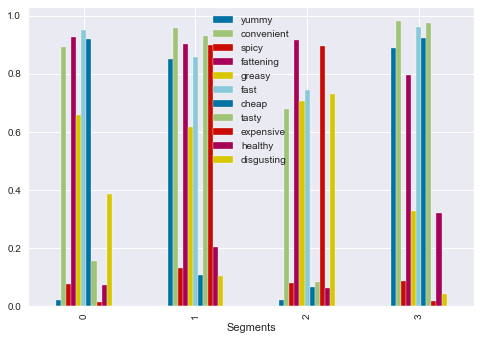

In [53]:
mcd["Segments"] = mapper_km[4]["predictions"]
mcd.groupby(["Segments"]).mean().plot(kind = 'bar')
plt.show()

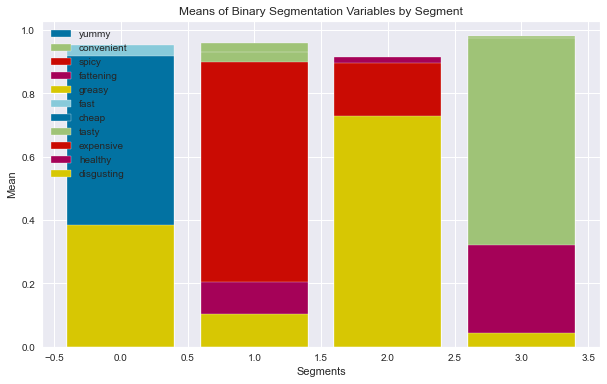

In [55]:
grouped = mcd.groupby("Segments").mean()

fig, ax = plt.subplots(figsize=(10, 6))
for col in grouped.columns:
    ax.bar(grouped.index, grouped[col], label=col)

ax.set_title("Means of Binary Segmentation Variables by Segment")
ax.set_xlabel("Segments")
ax.set_ylabel("Mean")

ax.legend()
plt.show()


* Segment 2: Thinks McDonalds is expensive, disgusting and Fattening. 
* Segment 3: Thinks it's Yummy, Cheap and tasty 
* Segment 0: Thinks it's greasy and Fattening 
* Segment 1: Expensive, Fatty but yummy and tasty 

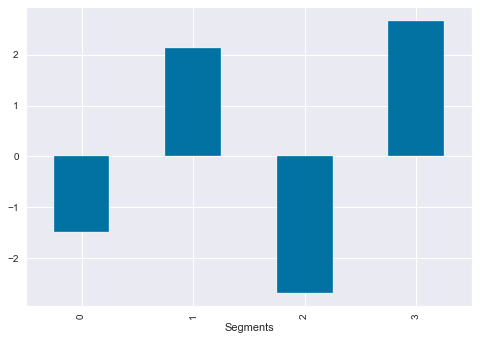

In [64]:
mcdonalds['Segments'] = mapper_km[4]["predictions"]
mcdonalds.groupby("Segments")["Like"].mean().plot(kind = 'bar')
plt.show()

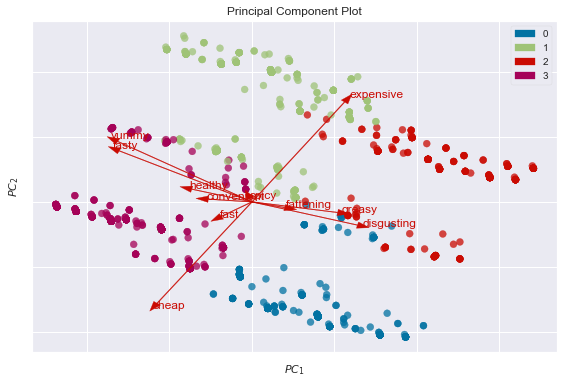

In [70]:
visualizer = PCADecomposition(scale = False, proj_features=True, colors = None )
X, y = mcd.iloc[:, :-1], mcd.iloc[:, -1]
visualizer.fit_transform(X, y)
visualizer.show()
plt.show()

#### Describing segments

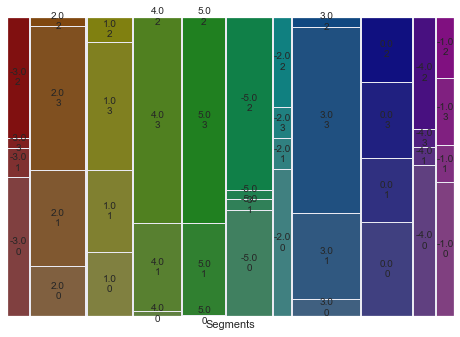

In [73]:
mosaic(mcdonalds, ['Like', 'Segments'], title='', axes_label=False)
plt.xlabel("Segments")
plt.show()